# Datasets

In [3]:
import os
import glob
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

UTKFACE_PATH = './data/utkface/UTKFace' 
FER_ROOT_PATH = './data/fer2013'         
BATCH_SIZE = 128
RANDOM_SEED = 42

# Percorsi per il salvataggio dei metadata (per riproducibilità)
METADATA_DIR = '../metadata_splits'
os.makedirs(METADATA_DIR, exist_ok=True)


def plot_distributions(age_df, emotion_df):
    """Genera grafici per visualizzare la distribuzione dei dati."""
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    plt.subplots_adjust(hspace=0.4)

    # 1. Age Distribution (Istogramma)
    sns.histplot(data=age_df, x='age', bins=30, kde=True, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Distribuzione Età (UTKFace)')
    axes[0, 0].set_xlabel('Età')

    # 2. Age Boxplot (per vedere outlier)
    sns.boxplot(x=age_df['age'], ax=axes[0, 1], color='lightgreen')
    axes[0, 1].set_title('Boxplot Età')

    # 3. Emotion Distribution (Bar Plot)
    sns.countplot(data=emotion_df, x='label', order=emotion_df['label'].value_counts().index, ax=axes[1, 0], palette='viridis')
    axes[1, 0].set_title('Distribuzione Emozioni (FER-2013)')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # 4. Pie Chart Emozioni (per vedere le percentuali)
    emotion_counts = emotion_df['label'].value_counts()
    axes[1, 1].pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', 7))
    axes[1, 1].set_title('Percentuale Classi Emozioni')

    plt.show()

In [4]:
def process_emotion_data(root_dir):
    """
    Scansiona le cartelle, crea split stratificato e calcola i pesi per la Loss.
    """
    print(f"Scansione Dataset Emozioni in: {root_dir}")

    paths = []
    labels = []

    # Cerca ricorsivamente tutti i file .jpg
    for filepath in glob.glob(os.path.join(root_dir, '**', '*.jpg'), recursive=True):
        # La label è il nome della cartella genitore
        classname = os.path.basename(os.path.dirname(filepath))
        paths.append(filepath)
        labels.append(classname)

    df = pd.DataFrame({'path': paths, 'label': labels})

    classes = sorted(df['label'].unique())
    class_to_idx = {cls: i for i, cls in enumerate(classes)}
    df['label_idx'] = df['label'].map(class_to_idx)

    train_df, val_df = train_test_split(
        df, test_size=0.2, stratify=df['label'], random_state=RANDOM_SEED
    )

    # 3. Calcolo Pesi Classi (Compute-Optimal per CrossEntropy)
    # Formula: n_samples / (n_classes * n_samples_per_class)
    # Calcolati SOLO sul training set
    train_labels = train_df['label_idx'].values
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )

    # Convertiamo in tensore
    weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

    print(f"   Note: Trovate {len(classes)} classi.")
    print(f"   Pesi calcolati: {weights_tensor}")

    return train_df, val_df, weights_tensor, class_to_idx

def process_age_data(root_dir):
    """
    Gestisce l'età: Binning per stratificazione e pesi per campione (Sample Weights).
    """
    print(f"Scansione Dataset Età in: {root_dir}")

    files = glob.glob(os.path.join(root_dir, "*.jpg"))
    ages = []
    paths = []

    for f in files:
        try:
            # UTKFace format: age_gender_race_date.jpg
            age = int(os.path.basename(f).split('_')[0])
            ages.append(age)
            paths.append(f)
        except:
            pass # Skip file corrotti o con nome errato

    df = pd.DataFrame({'path': paths, 'age': ages})

    # Binning per Stratificazione (5 anni per bin, con un bin extra per 80+)
    bins = list(range(0, 81, 5)) + [120]
    df['age_bin'] = pd.cut(df['age'], bins=bins, labels=False, include_lowest=True)

    train_df, val_df = train_test_split(
        df, test_size=0.2, stratify=df['age_bin'], random_state=RANDOM_SEED
    )

    # Calcolo Sample Weights (Peso specifico per ogni immagine)
    # Più una fascia è rara, più alto è il peso
    bin_counts = train_df['age_bin'].value_counts().sort_index()
    weights_per_bin = 1.0 / bin_counts

    # Normalizzazione (Media = 1.0) per stabilità numerica
    weights_per_bin = weights_per_bin / weights_per_bin.mean()

    # Assegniamo il peso a ogni riga del DataFrame
    train_df['sample_weight'] = train_df['age_bin'].map(weights_per_bin)
    val_df['sample_weight'] = 1.0 # In validazione peso standard

    print(f"   Note: Creati {len(bin_counts)} bin di età.")
    print(f"   Peso Max (Età rare): {weights_per_bin.max():.2f} | Peso Min (Età comuni): {weights_per_bin.min():.2f}")

    return train_df, val_df

### Dataframes


In [5]:
# Nomi file per il salvataggio
EMO_TRAIN_CSV = os.path.join(METADATA_DIR, 'train_emotion.csv')
EMO_VAL_CSV   = os.path.join(METADATA_DIR, 'val_emotion.csv')
EMO_META_PT   = os.path.join(METADATA_DIR, 'emotion_meta.pt')

AGE_TRAIN_CSV = os.path.join(METADATA_DIR, 'train_age.csv')
AGE_VAL_CSV   = os.path.join(METADATA_DIR, 'val_age.csv')

if os.path.exists(EMO_TRAIN_CSV) and os.path.exists(EMO_META_PT):
    print("Caricamento split Emozioni esistenti...")
    train_emotion_df = pd.read_csv(EMO_TRAIN_CSV)
    val_emotion_df = pd.read_csv(EMO_VAL_CSV)

    # Carichiamo metadata (pesi e mappa classi)
    meta = torch.load(EMO_META_PT)
    emotion_weights = meta['weights']
    class_to_idx = meta['class_map']
else:
    print("Creazione nuovi split Emozioni...")
    train_emotion_df, val_emotion_df, emotion_weights, class_to_idx = process_emotion_data(FER_ROOT_PATH)

    # Salvataggio
    train_emotion_df.to_csv(EMO_TRAIN_CSV, index=False)
    val_emotion_df.to_csv(EMO_VAL_CSV, index=False)
    torch.save({'weights': emotion_weights, 'class_map': class_to_idx}, EMO_META_PT)

print(f"Emozioni: Train {len(train_emotion_df)} | Val {len(val_emotion_df)}")

if os.path.exists(AGE_TRAIN_CSV):
    print("\nCaricamento split Età esistenti...")
    train_age_df = pd.read_csv(AGE_TRAIN_CSV)
    val_age_df = pd.read_csv(AGE_VAL_CSV)
else:
    print("\nCreazione nuovi split Età...")
    train_age_df, val_age_df = process_age_data(UTKFACE_PATH)

    # Salvataggio
    train_age_df.to_csv(AGE_TRAIN_CSV, index=False)
    val_age_df.to_csv(AGE_VAL_CSV, index=False)

print(f"Età: Train {len(train_age_df)} | Val {len(val_age_df)}")

Caricamento split Emozioni esistenti...
Emozioni: Train 28709 | Val 7178

Caricamento split Età esistenti...
Età: Train 18966 | Val 4742


C:\Users\antonio\AppData\Local\Temp\ipykernel_22580\2692400174.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(EMO_META_PT)


#### Visualizzazione


📊 Generazione grafici di distribuzione...


C:\Users\antonio\AppData\Local\Temp\ipykernel_4384\940226296.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=emotion_df, x='label', order=emotion_df['label'].value_counts().index, ax=axes[1, 0], palette='viridis')


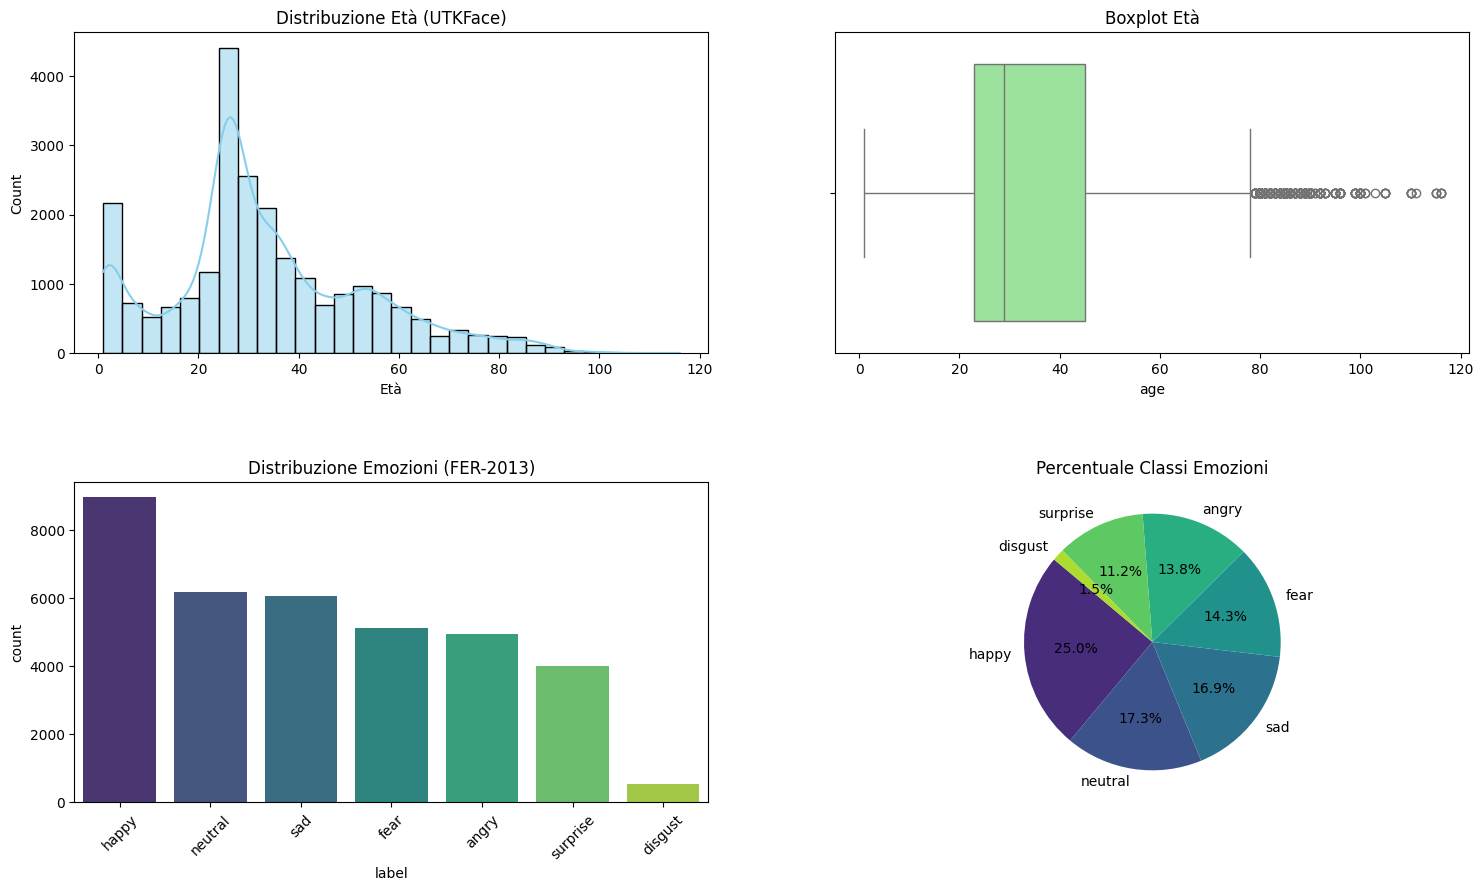

In [ ]:
print("\nGenerazione grafici di distribuzione...")
# Uniamo train e val solo per visualizzare la statistica globale
full_emotion_df = pd.concat([train_emotion_df, val_emotion_df])
full_age_df = pd.concat([train_age_df, val_age_df])
plot_distributions(full_age_df, full_emotion_df)